In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset, MFDataset
import xarray as xr
import pandas as pd
from scipy import spatial
from datetime import datetime
from datetime import timedelta
import os.path
import h5py as h5
from scipy.spatial import KDTree
import pyproj
from scipy.interpolate import griddata


Set the `YEAR` to forward. Advection will start from `START_DATE` (currently 15th April of the year specified).
Set the `SPACING`, i.e. the spacing of points in the grid to be forwarded. `SPACING=100` will forward every 100th grid point. Set `SPACING=1` to forward every grid point.
Set the number of `DAYS_TO_FORWARD`.

In [2]:
YEAR = 2020
START_DATE = f'{YEAR}-05-01 12:00:00'
SPACING = 8
DAYS_TO_FORWARD = 30

# prediction model params
R0 = 65.43
L = 16.14
TAU = 5.15
HNET = 0.025    # hnet between 20 and 40mm from Landy


### Inspect ice drift data files

Example file:

In [3]:
! ls /home/htweedie/melt_ponds/data/drift-velocities/archive/ice/drift_lr/merged/2019/09/ice_drift_nh_polstere-625_multi-oi_201909041200-201909061200.nc

/home/htweedie/melt_ponds/data/drift-velocities/archive/ice/drift_lr/merged/2019/09/ice_drift_nh_polstere-625_multi-oi_201909041200-201909061200.nc


Look at example file:

In [4]:
! ncdump -h /home/htweedie/melt_ponds/data/drift-velocities/archive/ice/drift_lr/merged/2019/09/ice_drift_nh_polstere-625_multi-oi_201909041200-201909061200.nc

netcdf ice_drift_nh_polstere-625_multi-oi_201909041200-201909061200 {
dimensions:
	time = 1 ;
	nv = 2 ;
	xc = 119 ;
	yc = 177 ;
variables:
	int Polar_Stereographic_Grid ;
		Polar_Stereographic_Grid:grid_mapping_name = "polar_stereographic" ;
		Polar_Stereographic_Grid:straight_vertical_longitude_from_pole = -45.f ;
		Polar_Stereographic_Grid:latitude_of_projection_origin = 90.f ;
		Polar_Stereographic_Grid:standard_parallel = 70.f ;
		Polar_Stereographic_Grid:false_easting = 0.f ;
		Polar_Stereographic_Grid:false_northing = 0.f ;
		Polar_Stereographic_Grid:semi_major_axis = 6378273.f ;
		Polar_Stereographic_Grid:semi_minor_axis = 6356890.f ;
		Polar_Stereographic_Grid:proj4_string = "+proj=stere +a=6378273 +b=6356889.44891 +lat_0=90 +lat_ts=70 +lon_0=-45" ;
	double time(time) ;
		time:axis = "T" ;
		time:long_name = "reference time of product" ;
		time:standard_name = "time" ;
		time:units = "seconds since 1978-01-01 00:00:00" ;
		time:calendar = "standard" ;
		time:bounds = "time_bnds

Available years: (2009 and 2024 are incomplete)

In [5]:
! ls /home/htweedie/melt_ponds/data/drift-velocities/archive/ice/drift_lr/merged/


2009  2011  2013  2015	2017  2019  2021  2023
2010  2012  2014  2016	2018  2020  2022  2024


In [6]:
# load the example file
#OSISAFfile = '/Users/micheltsamados/Google Drive/ADMINISTRATION/MosaicNERC2018/FieldTrip/WORK/DriftRackow/drift-velocities/archive/ice/drift_lr/merged/2017/09/ice_drift_nh_polstere-625_multi-oi_201708301200-201709011200.nc'
OSISAFfile = '/home/htweedie/melt_ponds/data/drift-velocities/archive/ice/drift_lr/merged/2019/09/ice_drift_nh_polstere-625_multi-oi_201909041200-201909061200.nc'
fl = Dataset(OSISAFfile)
#xc=fl.variables['xc']
#yc=fl.variables['yc']
#XC,YC=np.meshgrid(xc,yc)

# lon lat on grid
lon_start=np.copy(fl.variables['lon'])
lat_start=np.copy(fl.variables['lat'])

# lon lat at the end of the displacement
lon_end=np.squeeze(fl.variables['lon1'][0,:,:])
lat_end=np.squeeze(fl.variables['lat1'][0,:,:])

# max and min start and end coords
lon_end.min(), lon_end.max(), lon_start.min(), lon_start.max()


(-179.70926, 179.05727, -180.0, 179.52649)

### Load class and functions

In [7]:
class Buoys:
    
    global rad, r_earth
    rad=np.pi/180.0 # radiant <-> degree
    r_earth=6.3675*10**6 # radius of Earth in [m]
    
    def __init__(self, lon_start, lat_start, earliest_date_of_buoy, start_advect_date):
        print(lon_start)
        self.oldlon = lon_start * rad
        self.oldlat = lat_start * rad
        self.lon = lon_start * rad
        self.lat = lat_start * rad
        self.initlon = lon_start * rad
        self.initlat = lat_start * rad
        self.old_u = np.zeros(lon_start.shape)
        self.old_v = np.zeros(lon_start.shape)
        self.date = datetime.strptime(earliest_date_of_buoy, "%Y-%m-%d %H:%M:%S")
        self.startdates = start_advect_date
        #self.delta_x = np.zeros(lon_start.shape)
        #self.delta_y = np.zeros(lon_start.shape)
        #self.u_ice = np.zeros(lon_start.shape)
        #self.v_ice = np.zeros(lon_start.shape)
        
    def getdate(self):
        return self.date.strftime("%Y-%m-%d %H:%M:%S")
        
    def trajectory(self, new_u, new_v, delta_t):
        #print("Update buoy positions. Integrate for " + str(delta_t/3600.) + " hours.")
        
        #save old position in case the drifter leaves the domain
        self.oldlon = self.lon # radiant
        self.oldlat = self.lat # radiant
        
        #displacement vectors
        deltax1 = self.old_u * delta_t
        deltay1 = self.old_v * delta_t
        deltax2 = new_u * delta_t
        deltay2 = new_v * delta_t
        
        #Heun method (2nd order)
        self.lon = self.lon + (0.5*(deltax1 + deltax2) / (r_earth*np.cos(self.lat.values)) )
        self.lat = self.lat + (0.5*(deltay1 + deltay2) /  r_earth )
        
        # keep degree in range 0..360 and -90..90
        lon_deg = self.lon/rad % 360
        lat_deg = np.clip(self.lat/rad, -90., 90.)
        self.lon = lon_deg*rad
        self.lat = lat_deg*rad
        
        #update velocity here (old value was needed for heun method)
        self.old_u=new_u
        self.old_v=new_v
        
        # set positions to NaN before the buoy is supposed to move
        #idx=getindices_beforestart(self.getdate(), self.startdates)
        #lon_deg[idx] = np.nan
        #lat_deg[idx] = np.nan
        #self.lon[idx] = self.initlon[idx]
        #self.lat[idx] = self.initlat[idx]
        #self.old_u[idx]=0.
        #self.old_v[idx]=0.
        
        # update time stamp
        self.date = self.date + timedelta(seconds=delta_t)

        return lon_deg, lat_deg


In [8]:
r_earth=6.3675*10**6 # radius of Earth in [m]
rad=np.pi/180.0 # radiant <-> degree

# a useful function we'll need
def length_of_latitude_circle(lat=85.):
    return 2*np.pi*r_earth*np.cos(lat*rad) / 1000. # km


# find the buoys that are not to be advected yet (current date < start date)
def getindices_beforestart(currentdate, startdates):
        
    indices=np.zeros(np.shape(startdates),dtype='bool')
    for i,val in enumerate(startdates):
        # don't advect yet
        if currentdate < startdates[i]:
            indices[i]=True
            
    return indices


# load OSISAF data for Northern Hemisphere at a certain date
def loaddate_ofOSISAF(datestring, hemisphere='nh'):
    
    # convert datestring to datetime object
    thedate = datetime.strptime(datestring, "%Y-%m-%d %H:%M:%S")
    
    # let's construct the file name, 
    # e.g. drift-velocities/archive/ice/drift_lr/merged/2019/09/
    # ice_drift_nh_polstere-625_multi-oi_201909011200-201909031200.nc
    pathtofile = "/home/htweedie/melt_ponds/data/drift-velocities/archive/ice/drift_lr/merged/"
    # middle part
    middlefilename="ice_drift_"+hemisphere+"_polstere-625_multi-oi_"
    # e.g. 201907291200-201907311200 (48hr span)
    enddate=thedate + timedelta(days=2)
    # YYYY/MM/ (from end date)
    YYYYMM=enddate.strftime("%Y")+"/"+enddate.strftime("%m")+"/"
    endfilename= thedate.strftime("%Y%m%d%H%M") + "-" + enddate.strftime("%Y%m%d%H%M") + '.nc'
    
    # the OSISAF file to be loaded
    filename=pathtofile + YYYYMM + middlefilename + endfilename
    
    # take previous files in case there is a data gap
    sd=thedate
    ed=enddate
    while os.path.isfile(filename)!=True:
        # try previous file
        sd=sd - timedelta(days=1)
        ed=ed - timedelta(days=1)
        # YYYY/MM/ (from end date)
        YYYYMM=ed.strftime("%Y")+"/"+ed.strftime("%m")+"/"
        endfilename= sd.strftime("%Y%m%d%H%M") + "-" + ed.strftime("%Y%m%d%H%M") + '.nc'
        filename=pathtofile + YYYYMM + middlefilename + endfilename
        print('data gap: try previous file '+filename+' ...')
    
    #print("loading "+filename+ " ...") # Python3 needs brackets here
    
    # load the file
    fl = Dataset(filename)
    #xc=fl.variables['xc']
    #yc=fl.variables['yc']
    #XC,YC=np.meshgrid(xc,yc)
    
    # lon lat on grid
    lon_start=np.copy(fl.variables['lon'])
    lat_start=np.copy(fl.variables['lat'])

    # lon lat at the end of the displacement
    lon_end=np.squeeze(fl.variables['lon1'][0,:,:])
    lat_end=np.squeeze(fl.variables['lat1'][0,:,:])
    
    # close the file
    fl.close()
    
    # compute Ufield from end points and start points (48hour change)
    deltalon=lon_end-lon_start
    deltalon[deltalon>100.]=deltalon[deltalon>100.]-360.   # jump at -180..180
    deltalon[deltalon<-100.]=deltalon[deltalon<-100.]+360. # jump at -180..180
    Ufield=deltalon/48. *length_of_latitude_circle(lat=lat_start[:,:])/360. / 3.6 # km/h -> m/s
    
    # compute Vfield as well
    Vfield=(lat_end-lat_start)/48. *length_of_latitude_circle(lat=0.)/360. / 3.6 #km/h -> m/s
    
    return Ufield, Vfield, lon_start, lat_start


# nearest-neighbor interpolation, finds U,V at the position of the buoys using a fast KDTree method
def find_UV_atbuoy_pos(lon_start,lat_start, Ufield,Vfield, objects):
    
    # (lon,lat) tuples of the underlying grid
    A = np.array([lon_start[:,:].flatten(), lat_start[:,:].flatten()]).T # -180..180 assumed in OSISAF
    # change to -180..180 as assumed in OSISAF data; in the trajectory code its 0..360
    lon_adjust = objects.lon/rad
    lon_adjust[lon_adjust>180.] = lon_adjust[lon_adjust>180.]-360.
    # zip buoy (lon & lat) arrays to (lon,lat) tuples
    tuples = np.column_stack((lon_adjust, objects.lat/rad)) 
    # fast KDTree nearest neighbor method
    idx = spatial.KDTree(A).query(tuples)[1]
    
    return Ufield[idx], Vfield[idx]


def WGS84toEASE2N(lon, lat):
    '''Converts WGS84 coordinates to EASE2N.

    Params:
        lon (array): the WGS84 longitude to convert
        lat (array): the WGS84 latitude to convert

    Returns:
        (x, y): the corresponding EASE2N x and y coordinates
    '''

    proj_EASE2N = pyproj.Proj("+proj=laea +lon_0=0 +lat_0=90 +x_0=0 +y_0=0 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs")
    proj_WGS84 = pyproj.Proj("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs ")
    return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


def EASE2NtoWGS84(x, y):

    EASE2 = "+proj=laea +lon_0=0 +lat_0=90 +x_0=0 +y_0=0 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs"
    WGS84 = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
    transformer = pyproj.Transformer.from_crs(EASE2, WGS84)
    lon, lat = transformer.transform(x, y)
    return lon, lat


def load_MISR(MISR_path):
    '''Loads MISR data and coordinates from specified file path.

    Params:
        MISR_path (str): the file path from which to retrieve data

    Returns:
        data (np.array): roughness data retrieved from the specified file
        lon, lat
        x, y
    '''

    file = h5.File(MISR_path, 'r')
    
    # extract coord data
    lon = np.array(file['GeoLocation']['Longitude'])
    lat = np.array(file['GeoLocation']['Latitude'])
    x = np.array(file['GeoLocation']['x'])
    y = np.array(file['GeoLocation']['y'])

    # extract roughness data
    data = np.array(file['Roughness']['Roughness_2D_svm'])    
    
    file.close()

    return data, lon, lat, x, y


def predict_mpf(SIR, R0, l, tau, hnet):
    '''
    Predicts meltpond fraction given an input SIR, based on the model by Landy et al, 2015.
    '''
    R = R0 * np.exp(-l * SIR) + tau
    return (1 - np.exp(-R * hnet))


def interpolate_to_MISR(x_in, y_in, data, x_out, y_out):
    '''
    Interpolates data of the shape x_in, y_in to the shape of x_out, y_out.
    
    Params:
        data: the data to be interpolated
        x_in, y_in: the shape of the data to be interpolated
        
    Returns:
        x_out, y_out: the shape to which the data will be interpolated'''
    return griddata((x_in.ravel(), y_in.ravel()), data.ravel( ), (x_out.ravel(), y_out.ravel()), 'nearest').reshape(8000,8000) 


def format_date(year, month, day):
    return f"{year}-{month}-{day} 12:00:00"


### Configure points to be forwarded

In [9]:
# retrieve MPF coordinates and check that they overlap with roughness coords
coord_fn = '/home/htweedie/melt_ponds/data/OLCI/olci/LongitudeLatitudeGrid-n12500-Arctic.h5'
coords = h5.File(coord_fn, 'r')
mpf_lon =  np.array(coords['Longitudes'])
mpf_lat = np.array(coords['Latitudes'])
x_mpf, y_mpf = WGS84toEASE2N(mpf_lon, mpf_lat)

# check that MPF and roughness coords overlap
#plt.scatter(x_mpf.ravel()[::1000], y_mpf.ravel()[::1000])
#plt.scatter(x_sigma, y_sigma, s=10)
#plt.title('Check that coords line up')

/tmp/ipykernel_108578/1597454255.py:115: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


In [10]:
# point_lats = (sigma_lat[4000,3000], sigma_lat[4100,3200], sigma_lat[4200,3400], sigma_lat[4300,3600], sigma_lat[4400,3800], sigma_lat[4500,4000])
# point_lons = (sigma_lon[4000,3000], sigma_lon[4100,3200], sigma_lon[4200,3400], sigma_lon[4300,3600], sigma_lon[4400,3800], sigma_lon[4500,4000])


#all_lats = sigma_lat[::100,::100].ravel().tolist()
#all_lons = sigma_lon[::100,::100].ravel().tolist()
#all_sigma = sigma[::100,::100].ravel().tolist()

#point_lats = np.argwhere(isinstance(all_lats, float))

# retrieve MISR data and coordinates
fn = f'/home/ssureen/MISR_data_monthly/April {YEAR} Roughness.h5'
sigma, sigma_lon, sigma_lat, sigma_x, sigma_y = load_MISR(fn)

# take an even subset of the data to reduce computational requirements
all_lats = sigma_lat[::SPACING, ::SPACING].ravel()
all_lons = sigma_lon[::SPACING, ::SPACING].ravel()
all_sigma = sigma[::SPACING, ::SPACING].ravel()

# remove NaNs
#sigma_nan_indices = np.argwhere(np.isnan(all_sigma)).ravel()
#sigma_cleaned = all_sigma[np.setdiff1d(range(len(all_sigma)), sigma_nan_indices).tolist()]
#lats_cleaned = all_lats[np.setdiff1d(range(len(all_lats)), sigma_nan_indices).tolist()]
#lons_cleaned = all_lons[np.setdiff1d(range(len(all_lons)), sigma_nan_indices).tolist()]

sigma_cleaned = all_sigma
lats_cleaned = all_lats
lons_cleaned = all_lons

print(f'Sigma: {np.shape(all_sigma)}')
print(f'Lats: {np.shape(all_lats)}')
print(f'Lons: {np.shape(all_lons)}')

#print(f'Number of NaNs: {np.shape(sigma_nan_indices)}')

print(f'Sigma cleaned: {np.shape(sigma_cleaned)}')
print(f'Lats cleaned: {np.shape(lats_cleaned)}')
print(f'Lons cleaned: {np.shape(lons_cleaned)}')

num_points = len(lons_cleaned)
delta_t = 86400

earliest_date = START_DATE
advect_start_date = START_DATE
dates = [advect_start_date]

lons = np.zeros((1, num_points))*np.nan
lats = np.zeros((1, num_points))*np.nan
mpfs = np.zeros((1, num_points))*np.nan
lats_df = pd.DataFrame(data=lats, index=dates)
lons_df = pd.DataFrame(data=lons, index=dates)
mpfs_df = pd.DataFrame(data=mpfs, index=dates)

lats_df.loc[advect_start_date] = lats_cleaned # np.arange(90.,110.,1.)
lons_df.loc[advect_start_date] = lons_cleaned # np.arange(90.,110.,1.)

date = datetime.strptime(advect_start_date, "%Y-%m-%d %H:%M:%S")
start_YYYYMMDD = date.strftime("%Y")+date.strftime("%m")+date.strftime("%d")

try:
    if YEAR >= 2017 and YEAR <= 2023:
        fn = f'/home/htweedie/melt_ponds/data/OLCI/olci/{YEAR}/data/mpd1_{start_YYYYMMDD}.nc'
    elif YEAR >= 2002 and YEAR <= 2011:
        fn = f'/home/htweedie/melt_ponds/data/MERIS/mecosi/{YEAR}/data/mpd1_{start_YYYYMMDD}.nc'
    ds = xr.open_dataset(fn)
    mpf = ds['mpf']
except Exception as e:
    mpf = np.zeros(num_points)
    mpf[:] = np.nan
    print(f'Data could not be retrieved for advection start date, {date}: {e}')

tree = KDTree(list(zip(x_mpf.ravel(), y_mpf.ravel())))

x_sigma, y_sigma = WGS84toEASE2N(all_lons, all_lats)
max_radius = 10000
indices_within_grid = tree.query_ball_point(list(zip(x_sigma, y_sigma)), r = max_radius)

# calculate the mean MPF within the radius for each sigma grid point
if len(indices_within_grid) > 0:
    mean_mpf = np.zeros(num_points)
    for i in range(num_points):
        mean_mpf[i] = np.mean(np.asarray(mpf).ravel()[indices_within_grid[i]])

# convert 0s to nans and append to list
mean_mpf[mean_mpf==0] = np.nan

mpfs_df.loc[advect_start_date] = np.asarray(mean_mpf).ravel()

points = Buoys(lons_df.loc[advect_start_date], lats_df.loc[advect_start_date], advect_start_date, earliest_date)


Sigma: (1000000,)
Lats: (1000000,)
Lons: (1000000,)
Sigma cleaned: (1000000,)
Lats cleaned: (1000000,)
Lons cleaned: (1000000,)


/tmp/ipykernel_108578/1597454255.py:115: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


0         -45.000000
1         -44.942638
2         -44.885166
3         -44.827576
4         -44.769867
             ...    
999995    135.230530
999996    135.172729
999997    135.115036
999998    135.057465
999999    135.000000
Name: 2020-05-01 12:00:00, Length: 1000000, dtype: float64


In [13]:
len(indices_within_grid)

1000000

### Forward points

Forward points one day at a time using daily sea ice advection data. At each day, map that day's SIR to MPF grid and store.

Find corresponding MPF for each SIR point (interpolate backwards). Replicate latitude analysis.

In [7]:
forwarded_mpfs = []
pred_mpfs = []
for i in np.arange(1, DAYS_TO_FORWARD+1):
    print('This is loop #'+str(i))

    Ufield, Vfield, lon_start, lat_start = loaddate_ofOSISAF(points.getdate(), hemisphere='nh')
    U,V = find_UV_atbuoy_pos(lon_start, lat_start, Ufield.flatten(),Vfield.flatten(), points)

    # don't advect buoys when there is no ice
    fixed=np.logical_or(U.mask, V.mask)
    U[fixed]=0.
    V[fixed]=0.

    LON,LAT = points.trajectory(U, V, delta_t=delta_t) # U,V in m/s, delta_t in seconds

    # create dataframe with new lats and lons
    new_lons = pd.DataFrame(LON.rename(points.getdate())).T
    new_lats = pd.DataFrame(LAT.rename(points.getdate())).T

    # add dataframe with new lats and lons to original one
    lons_df = pd.concat([lons_df, new_lons])
    lats_df = pd.concat([lats_df, new_lats])

    x_sigma, y_sigma = WGS84toEASE2N(new_lons, new_lats)

    # Define a KD-tree using final lons and lats
    tree = KDTree(list(zip(x_sigma.ravel(), y_sigma.ravel())))

    # Query the tree to find all points within final_lons and final_lats grids
    max_radius = 10000
    indices_within_grid = tree.query_ball_point(list(zip(x_mpf.ravel(), y_mpf.ravel())), r = max_radius)

    # calculate the mean of roughnesses within the radius for each MPF grid point
    mean_sigma = np.zeros(len(indices_within_grid))
    for i in range(len(indices_within_grid)):
        if len(indices_within_grid[i]) > 0:
            mean_sigma[i] = np.mean(sigma_cleaned[indices_within_grid[i]])

    # convert 0s to nans and append to list
    mean_sigma[mean_sigma==0] = np.nan
    forwarded_mpfs.append(mean_sigma)

    pred_mpfs.append(predict_mpf(mean_sigma, R0, L, TAU, HNET))


This is loop #1


/tmp/ipykernel_444507/1399926597.py:115: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


This is loop #2


/tmp/ipykernel_444507/1399926597.py:115: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


This is loop #3


/tmp/ipykernel_444507/1399926597.py:115: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


This is loop #4


/tmp/ipykernel_444507/1399926597.py:115: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


This is loop #5


/tmp/ipykernel_444507/1399926597.py:115: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


This is loop #6


/tmp/ipykernel_444507/1399926597.py:115: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


This is loop #7


/tmp/ipykernel_444507/1399926597.py:115: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


This is loop #8


/tmp/ipykernel_444507/1399926597.py:115: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


This is loop #9


/tmp/ipykernel_444507/1399926597.py:115: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


This is loop #10


/tmp/ipykernel_444507/1399926597.py:115: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


This is loop #11


/tmp/ipykernel_444507/1399926597.py:115: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


This is loop #12


/tmp/ipykernel_444507/1399926597.py:115: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


This is loop #13


/tmp/ipykernel_444507/1399926597.py:115: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


This is loop #14


/tmp/ipykernel_444507/1399926597.py:115: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


This is loop #15


/tmp/ipykernel_444507/1399926597.py:115: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


This is loop #16


/tmp/ipykernel_444507/1399926597.py:115: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


This is loop #17


/tmp/ipykernel_444507/1399926597.py:115: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


This is loop #18


/tmp/ipykernel_444507/1399926597.py:115: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


This is loop #19


/tmp/ipykernel_444507/1399926597.py:115: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


This is loop #20


/tmp/ipykernel_444507/1399926597.py:115: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


This is loop #21


/tmp/ipykernel_444507/1399926597.py:115: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


This is loop #22


/tmp/ipykernel_444507/1399926597.py:115: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


This is loop #23


/tmp/ipykernel_444507/1399926597.py:115: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


This is loop #24


/tmp/ipykernel_444507/1399926597.py:115: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


This is loop #25


/tmp/ipykernel_444507/1399926597.py:115: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


This is loop #26


/tmp/ipykernel_444507/1399926597.py:115: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


This is loop #27


/tmp/ipykernel_444507/1399926597.py:115: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


This is loop #28


/tmp/ipykernel_444507/1399926597.py:115: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


This is loop #29


/tmp/ipykernel_444507/1399926597.py:115: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


This is loop #30


/tmp/ipykernel_444507/1399926597.py:115: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Current tree is the size of the mpf grid: 608 x 896.  
Sigma x, y is the size of the spaced grid.

Within each sigma grid cell, find the mean MPF.

In [ ]:
forwarded_mpfs = []
pred_mpfs = []
for i in np.arange(1, DAYS_TO_FORWARD+1):
    print('This is loop #'+str(i))

    Ufield, Vfield, lon_start, lat_start = loaddate_ofOSISAF(points.getdate(), hemisphere='nh')
    U,V = find_UV_atbuoy_pos(lon_start, lat_start, Ufield.flatten(),Vfield.flatten(), points)

    # don't advect buoys when there is no ice
    fixed=np.logical_or(U.mask, V.mask)
    U[fixed]=0.
    V[fixed]=0.

    LON,LAT = points.trajectory(U, V, delta_t=delta_t) # U,V in m/s, delta_t in seconds

    # create dataframe with new lats and lons
    new_lons = pd.DataFrame(LON.rename(points.getdate())).T
    new_lats = pd.DataFrame(LAT.rename(points.getdate())).T

    # add dataframe with new lats and lons to original one
    lons_df = pd.concat([lons_df, new_lons])
    lats_df = pd.concat([lats_df, new_lats])
    
    x_sigma, y_sigma = WGS84toEASE2N(new_lons, new_lats)

    # get and format current datestring
    date = datetime.strptime(points.getdate(), "%Y-%m-%d %H:%M:%S")
    YYYYMMDD=date.strftime("%Y")+date.strftime("%m")+date.strftime("%d")

    # retrieve MPF data for this day
    try:
        if YEAR >= 2017 and YEAR <= 2023:
            fn = f'/home/htweedie/melt_ponds/data/OLCI/olci/{YEAR}/data/mpd1_{YYYYMMDD}.nc'
        elif YEAR >= 2002 and YEAR <= 2011:
            fn = f'/home/htweedie/melt_ponds/data/MERIS/mecosi/{YEAR}/data/mpd1_{YYYYMMDD}.nc'
        ds = xr.open_dataset(fn)
        mpf = ds['mpf']
        print(f'Data retrieved for {date}')
    except Exception as e:
        mpf = np.zeros(896*608)
        mpf[:] = np.nan
        print(f'Data could not be retrieved for {date}: {e}')

    # Query the tree to find all points within final_lons and final_lats grids
    max_radius = 10000
    indices_within_grid = tree.query_ball_point(list(zip(x_sigma.ravel(), y_sigma.ravel())), r = max_radius)

    # calculate the mean MPF within the radius for each sigma grid point
    if len(indices_within_grid) > 0:
        mean_mpf = np.zeros(num_points)
        for i in range(num_points):
            mean_mpf[i] = np.mean(np.asarray(mpf).ravel()[indices_within_grid[i]])

    # convert 0s to nans and append to list
    mean_mpf[mean_mpf==0] = np.nan
    forwarded_mpfs.append(mean_mpf)

    ind = format_date(date.strftime("%Y"), date.strftime("%m"), date.strftime("%d"))
    new_mpfs = pd.DataFrame(data=np.asarray(mean_mpf).reshape(1, len(np.asarray(mean_mpf).ravel())), index=[ind])
    mpfs_df = pd.concat([mpfs_df, new_mpfs])

    #pred_mpfs.append(predict_mpf(mean_mpf, R0, L, TAU, HNET))

mpfs_df

In [23]:
date = datetime.strptime(advect_start_date, "%Y-%m-%d %H:%M:%S")
start_YYYYMMDD = date.strftime("%Y")+date.strftime("%m")+date.strftime("%d")

In [24]:
mpfs_df.to_pickle(f'/home/htweedie/melt_ponds/data/forwarded_mpfs/mpf_from_{start_YYYYMMDD}_spacing_{SPACING}.pkl')


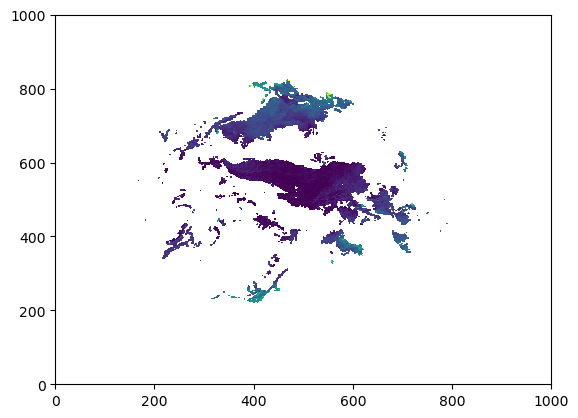

In [27]:
width = int(np.sqrt(len(indices_within_grid)))
plt.pcolor(np.asarray(mpfs_df.loc[format_date(YEAR,'05','31')]).reshape(width,width))

In [ ]:
lons_df = pd.read_pickle('/home/htweedie/melt_ponds/data/forwarded_coords/2020_lons_forwarded_120_days_spacing_100.pkl')
lats_df = pd.read_pickle('/home/htweedie/melt_ponds/data/forwarded_coords/2020_lats_forwarded_120_days_spacing_100.pkl')


/tmp/ipykernel_179456/1745561078.py:1: RuntimeWarning: Mean of empty slice
  mean_forwarded_mpf = np.nanmean(forwarded_mpfs, axis=0)
/tmp/ipykernel_179456/1745561078.py:7: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


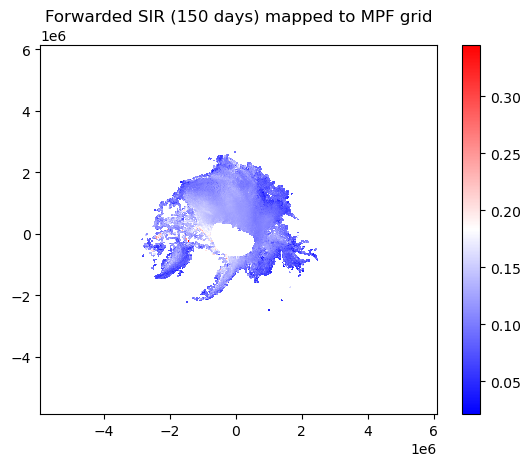

In [ ]:
mean_forwarded_mpf = np.nanmean(forwarded_mpfs, axis=0)
np.shape(mean_forwarded_mpf)

plt.set_cmap('bwr')
plt.pcolor(x_mpf, y_mpf, mean_forwarded_mpf.reshape(896, 608))
plt.title(f'Forwarded SIR ({DAYS_TO_FORWARD} days) mapped to MPF grid')
plt.colorbar()


In [ ]:
np.shape(pred_mpfs[30:120])

(90, 544768)

/tmp/ipykernel_179456/3495171698.py:1: RuntimeWarning: Mean of empty slice
  mean_pred_mpfs = np.nanmean(pred_mpfs[30:150], axis=0)


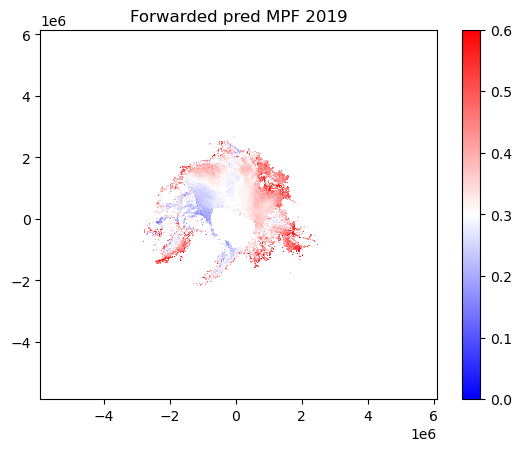

<Figure size 640x480 with 0 Axes>

In [ ]:
mean_pred_mpfs = np.nanmean(pred_mpfs[30:150], axis=0)

plt.set_cmap('bwr')
plt.pcolormesh(x_mpf, y_mpf, mean_pred_mpfs.reshape(896, 608), vmin=0, vmax=0.6)
#plt.pcolormesh(x_mpf, y_mpf, mpf, vmin=0, vmax=0.6)
plt.title(f'Forwarded pred MPF {YEAR}')
plt.colorbar()
plt.show()

plt.savefig(f'/home/htweedie/melt_ponds/forwarded_mpf_figs/{YEAR}_{DAYS_TO_FORWARD}_days_{SPACING}_spacing.png', format='png')

In [ ]:
print(f"Retrieving MPF data and calculating monthly means:")
months = ['05', '06', '07', '08']
YEAR = 2019

monthly_mpfs = []
for month in months:
    # set the number of days for the given month
    match month:
        case '05' | '07' | '08':
            days = 31
        case '06':
            days = 30

    # initialise empty list to store mpf for each day
    daily_mpfs = []
    for day in range(days):
        # start days from 1 rather than 0
        day += 1
        # configure days as strings to work with file names
        if day < 10:
            day = f'0{day}'
        else:
            day = str(day)

        # retrieve data for given day. If the file doesn't exist, skip it.
        try:
            fn = f'/home/htweedie/melt_ponds/data/OLCI/olci/{2019}/data/mpd1_{2019}{month}{day}.nc'
            ds = xr.open_dataset(fn)
            mpf = ds['mpf']
            daily_mpfs.append(np.array(mpf))
        except Exception as e:
            print(f'Data could not be retrieved for {day}/{month}/{2019}: {e}')
            continue

    # calculate the mean of the current month and save as .npy
    month_mean = np.nanmean(daily_mpfs, 0)
    monthly_mpfs.append(month_mean)
    #fn = f'/home/htweedie/melt_ponds/data/MERIS/mecosi/{2019}/mean_{month}_{2019}.npy'
    #np.save(fn, month_mean)
    print(f"{month} mean calculated.")

# find mean of all months
mean_summer_mpf = np.nanmean(monthly_mpfs, 0)
print(f"{YEAR} mean calculated.")


Retrieving MPF data and calculating monthly means:


/tmp/ipykernel_179456/758938560.py:36: RuntimeWarning: Mean of empty slice
  month_mean = np.nanmean(daily_mpfs, 0)


05 mean calculated.
06 mean calculated.
07 mean calculated.
08 mean calculated.
2019 mean calculated.


/tmp/ipykernel_179456/758938560.py:43: RuntimeWarning: Mean of empty slice
  mean_summer_mpf = np.nanmean(monthly_mpfs, 0)


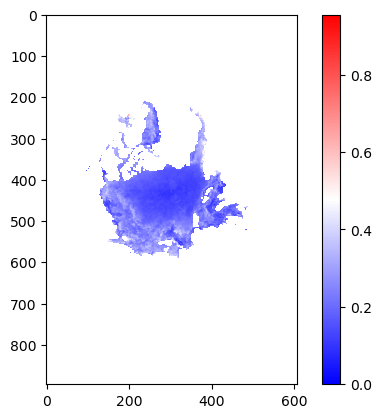

In [ ]:
plt.set_cmap('bwr')
plt.imshow(mean_summer_mpf)
plt.colorbar()

### Plot trajectories

Calculate velocity magnitude map:

In [30]:
# Construct U,V sea ice velocity here for plotting
# calculate magnitude of velocities and store as plotfield
deltalon = lon_end-lon_start
deltalon[deltalon>100.] = deltalon[deltalon>100.]-360. # jump at -180..180
deltalon[deltalon<-100.] = deltalon[deltalon<-100.]+360. # jump at -180..180
Ufield=deltalon/48. *length_of_latitude_circle(lat=lat_start[:,:])/360. * 3.6 # km/h -> m/s
Vfield=(lat_end-lat_start)/48. *length_of_latitude_circle(lat=0.)/360. * 3.6 #km/h -> m/s
plotfield = np.squeeze(np.sqrt(Ufield**2 + Vfield**2)) # m/s
#plotfield=Ufield


/tmp/ipykernel_6491/2439582816.py:8: RuntimeWarning: invalid value encountered in sqrt
  plotfield = np.squeeze(np.sqrt(Ufield**2 + Vfield**2)) # m/s


Plot starting locations of all points to be forwarded:

/tmp/ipykernel_6491/683698351.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(lons[0][0], lats_df[0][0], 'ro')


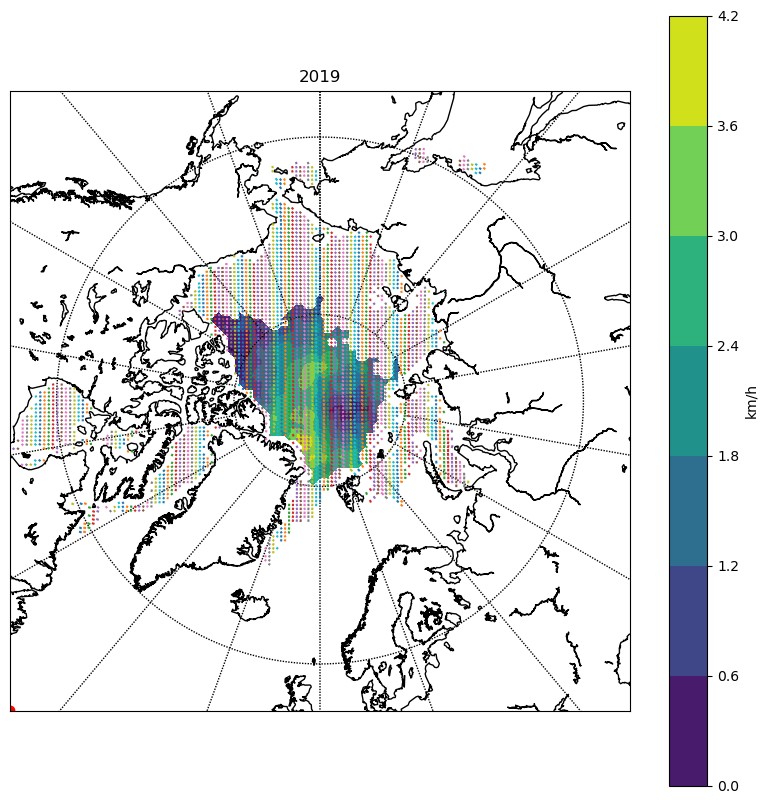

In [31]:
# don't plot if the spacing is lower than 50 (takes a while)
if SPACING >= 50:
    fig = plt.figure(figsize=(10,10))
    plt.set_cmap('viridis')
    m = Basemap(projection='npstere',boundinglat=55,lon_0=0,resolution='l') # -180..180
    #m = Basemap(projection='npstere',boundinglat=75,lon_0=0,resolution='l') # -180..180
    #m = Basemap(projection='robin',boundinglat=40,lon_0=0,resolution='l')

    m.drawcoastlines()
    #m.fillcontinents(color='0.1',lake_color='lightblue')

    # draw parallels and meridians.
    m.drawparallels(np.arange(-80.,81.,20.))
    m.drawmeridians(np.arange(-180.,181.,20.))
    #m.drawmapboundary(fill_color='lightblue')

    lon_map,lat_map=m(lon_start[:,:],lat_start[:,:])
    m.contourf(lon_map, lat_map, plotfield)

    # COMPUTED TRAJECTORY FROM Uice Vice
    for point_num in np.arange(0, num_points):
        a = np.ma.array(lons_df[point_num][0:2].values, mask=np.isnan(lons_df[point_num][0:2].values))
        b = np.ma.array(lats_df[point_num][0:2].values, mask=np.isnan(lats_df[point_num][0:2].values))
        lon_traj,lat_traj=m(a,b)
        #m.plot(lon_traj, lat_traj,'m')
        m.plot(lon_traj, lat_traj)
        
    plt.plot(lons[0][0], lats_df[0][0], 'ro')

    cbar=plt.colorbar()
    cbar.set_label('km/h')
    plt.title(f'{2019}')
    plt.show()


Plot full trajectories:

/tmp/ipykernel_6491/689294281.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(lons[0][0], lats_df[0][0], 'ro')


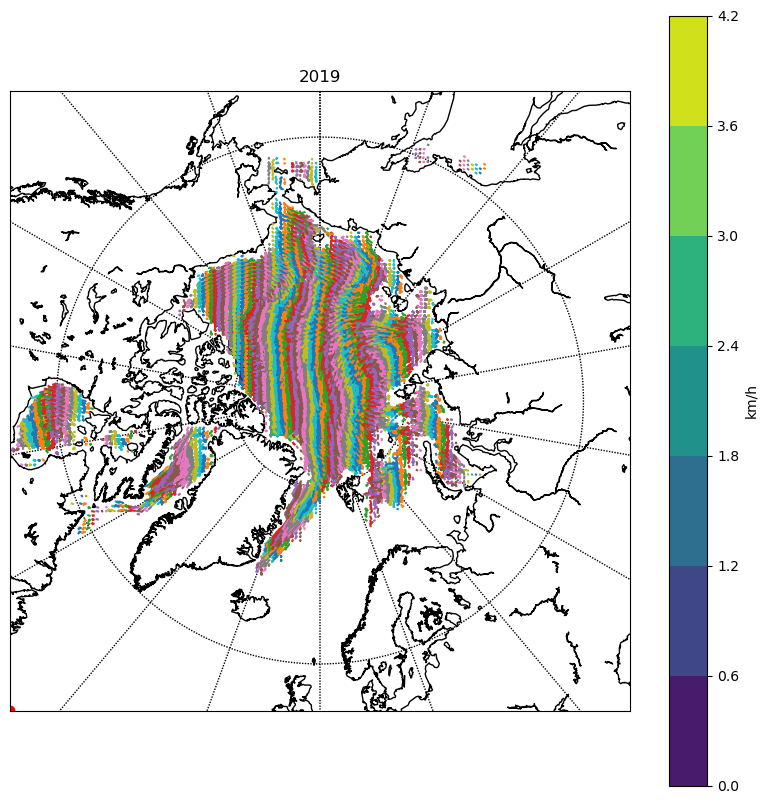

In [32]:
# don't plot if the spacing is lower than 50 (takes a while)
if SPACING >= 50:
    fig = plt.figure(figsize=(10,10))
    plt.set_cmap('viridis')
    m = Basemap(projection='npstere',boundinglat=55,lon_0=0,resolution='l') # -180..180
    #m = Basemap(projection='npstere',boundinglat=75,lon_0=0,resolution='l') # -180..180
    #m = Basemap(projection='robin',boundinglat=40,lon_0=0,resolution='l')

    m.drawcoastlines()
    #m.fillcontinents(color='0.1',lake_color='lightblue')

    # draw parallels and meridians.
    m.drawparallels(np.arange(-80.,81.,20.))
    m.drawmeridians(np.arange(-180.,181.,20.))
    #m.drawmapboundary(fill_color='lightblue')

    lon_map,lat_map=m(lon_start[:,:],lat_start[:,:])
    m.contourf(lon_map, lat_map, plotfield)

    # COMPUTED TRAJECTORY FROM Uice Vice
    for point_num in np.arange(0, num_points):
        a = np.ma.array(lons_df[point_num][:].values, mask=np.isnan(lons_df[point_num][:].values))
        b = np.ma.array(lats_df[point_num][:].values, mask=np.isnan(lats_df[point_num][:].values))
        lon_traj,lat_traj = m(a,b)
        #m.plot(lon_traj, lat_traj,'m')
        m.plot(lon_traj, lat_traj)
        
    plt.plot(lons[0][0], lats_df[0][0], 'ro')

    cbar=plt.colorbar()
    cbar.set_label('km/h')
    plt.title(f'{2019}')
    plt.show()


### Timeseries Analysis

Single point, observed MPF:

Text(0, 0.5, 'MPF')

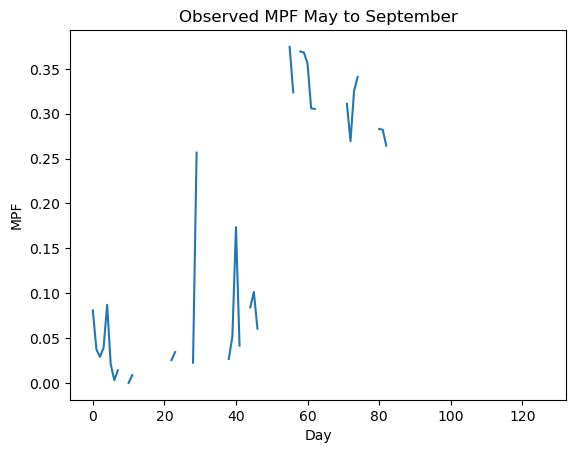

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

MONTHS = ('05', '06', '07', '08', '09')
YEAR = 2020
POINT_X, POINT_Y = 250, 400

# configure list of dates for which files will be loaded
dates = []
for month in MONTHS:
    if month in ('09','04','06','11'):
        n_days = 30
    elif month == '02':
        n_days = 28
    else:
        n_days = 31

    for day in range(n_days):
        # configure day string
        day += 1
        if day < 10:
            day_str = f'0{day}'
        else:
            day_str = str(day)

        dates.append(f'{YEAR}{month}{day_str}')
    
# load files and extract data for specified point
mpf_timeseries = []
for date in dates:
    fn = f'/home/htweedie/melt_ponds/data/OLCI/olci/{YEAR}/data/mpd1_{date}.nc'
    ds = xr.open_dataset(fn)
    mpf = np.asarray(ds['mpf'])
    mpf_timeseries.append(mpf[POINT_Y, POINT_X])


plt.plot(mpf_timeseries)
plt.title('Observed MPF May to September')
plt.xlabel('Day')
plt.ylabel('MPF')

All points, average observed MPF:

In [ ]:
MONTHS = ('05', '06', '07', '08', '09')
YEAR = 2020
SPACING = 20

# configure list of dates for which files will be loaded
dates = []
for month in MONTHS:
    if month in ('09','04','06','11'):
        n_days = 30
    elif month == '02':
        n_days = 28
    else:
        n_days = 31

    for day in range(n_days):
        # configure day string
        day += 1
        if day < 10:
            day_str = f'0{day}'
        else:
            day_str = str(day)

        dates.append(f'{YEAR}{month}{day_str}')
    
# load files and extract data for specified point
mpf_timeseries_mean = []
mpf_timeseries_max = []
mpf_timeseries_min = []
for date in dates:
    fn = f'/home/htweedie/melt_ponds/data/OLCI/olci/{YEAR}/data/mpd1_{date}.nc'
    ds = xr.open_dataset(fn)
    mpf = np.asarray(ds['mpf'])
    mpf_timeseries_mean.append(np.nanmean(mpf))
    mpf_timeseries_max.append(np.nanmax(mpf))
    mpf_timeseries_min.append(np.nanmin(mpf))


Text(0, 0.5, 'MPF')

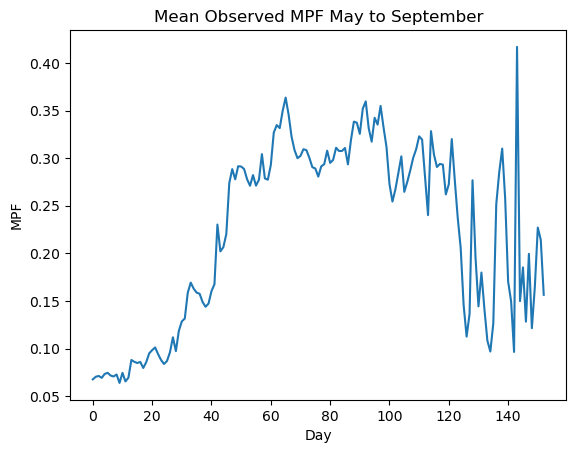

In [ ]:
plt.plot(mpf_timeseries_mean)
plt.title('Mean Observed MPF May to September')
plt.xlabel('Day')
plt.ylabel('MPF')


Text(0, 0.5, 'MPF')

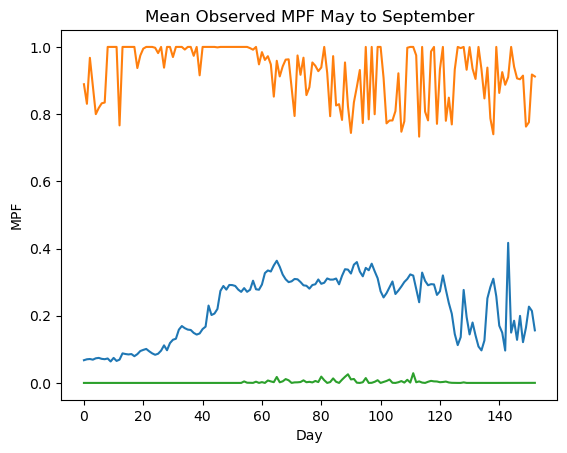

In [ ]:
plt.plot(mpf_timeseries_mean)
plt.plot(mpf_timeseries_max)
plt.plot(mpf_timeseries_min)
plt.title('Mean Observed MPF May to September')
plt.xlabel('Day')
plt.ylabel('MPF')

In [ ]:
np.shape(pred_mpfs)

(150, 544768)

In [ ]:
pred_mpfs_means = []
for i in range(150):
    pred_mpfs_means.append(np.nanmean(pred_mpfs[i,:,:].ravel()))
np.shape(pred_mpfs_means)

TypeError: list indices must be integers or slices, not tuple

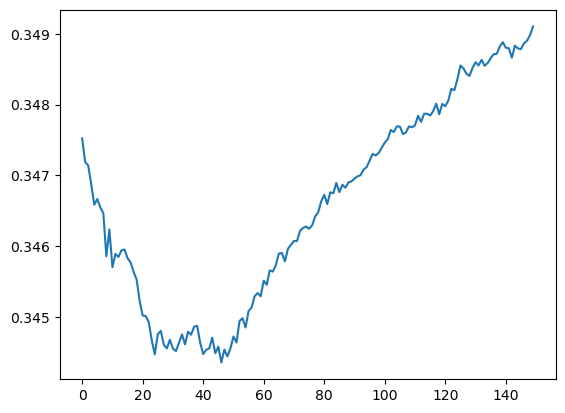

In [ ]:
plt.plot(pred_mpfs_means)

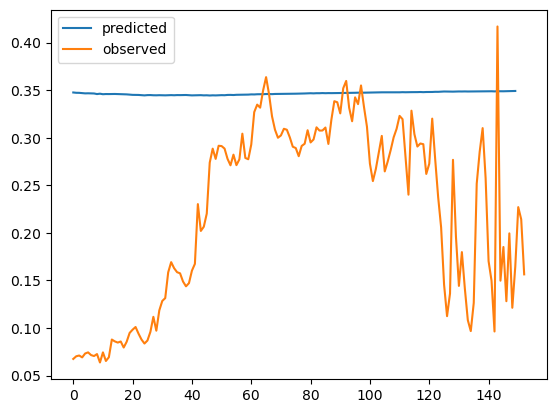

In [ ]:
plt.plot(pred_mpfs_means, label='predicted')
plt.plot(mpf_timeseries_mean, label='observed')
plt.legend()

(896, 608)


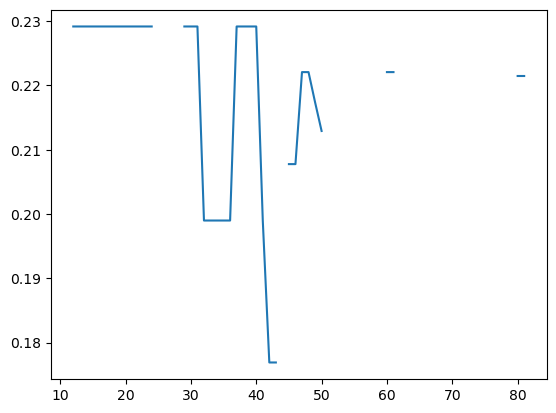

In [ ]:
pred_mpfs = np.asarray(pred_mpfs).reshape(150, 896, 608)
print(np.shape(pred_mpfs[50]))

pred_timeseries = pred_mpfs[:,POINT_Y,POINT_X]
np.shape(pred_timeseries)

plt.plot(pred_timeseries)